## EDA

In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier

# Configuración de rutas de datos
ruta_base = 'data/data_format1/data_format1/'
ruta_train = ruta_base + 'train_format1.csv'
ruta_test = ruta_base + 'test_format1.csv'
ruta_info_usuarios = ruta_base + 'user_info_format1.csv'
ruta_log_usuarios = ruta_base + 'user_log_format1.csv'

# Cargar datos
datos_train = pd.read_csv(ruta_train)
datos_test = pd.read_csv(ruta_test)
info_usuarios = pd.read_csv(ruta_info_usuarios)
log_usuarios = pd.read_csv(ruta_log_usuarios)

# Fusionar y marcar datos de entrenamiento y prueba
datos_train['tipo'] = 'train'
datos_test['tipo'] = 'test'
conjunto_datos = pd.concat([datos_train, datos_test.drop('prob', axis=1)], ignore_index=True)

# Optimizar tipos de datos para reducir uso de memoria
log_usuarios = log_usuarios.astype({
    'user_id': 'int32',
    'item_id': 'int32',
    'cat_id': 'int16',
    'seller_id': 'int16'
})
log_usuarios.rename(columns={'seller_id': 'merchant_id'}, inplace=True)
log_usuarios['brand_id'] = log_usuarios['brand_id'].fillna(0).astype('int16')
log_usuarios['action_type'] = log_usuarios['action_type'].astype('int8')

# Transformar fechas en 'time_stamp' a días transcurridos desde la fecha mínima
fecha_base = pd.to_datetime(log_usuarios['time_stamp'], format='%m%d').min()
log_usuarios['time_stamp'] = (pd.to_datetime(log_usuarios['time_stamp'], format='%m%d') - fecha_base).dt.days
log_usuarios['time_stamp'] = log_usuarios['time_stamp'].astype('int16')

# Imputar valores nulos y ajustar tipos en info_usuarios
info_usuarios['age_range'].fillna(0, inplace=True)
info_usuarios['gender'].fillna(2, inplace=True)
info_usuarios = info_usuarios.astype({'age_range': 'int8', 'gender': 'int8'})

# Codificación de variable categórica 'age_range'
encoder = OneHotEncoder(sparse_output=False)
edad_codificada = encoder.fit_transform(info_usuarios[['age_range']])

# Crear un DataFrame de las columnas codificadas con nombres personalizados para evitar problemas de nombres
nombres_columnas = [f"age_{int(cat)}" for cat in encoder.categories_[0]]
edad_codificada_df = pd.DataFrame(edad_codificada, columns=nombres_columnas)

# Alinear el índice de 'edad_codificada_df' con 'info_usuarios' antes de concatenar
edad_codificada_df.index = info_usuarios.index

# Concatenar las columnas codificadas al DataFrame de info_usuarios
info_usuarios = pd.concat([info_usuarios, edad_codificada_df], axis=1)

C:\Users\daher\AppData\Local\Temp\ipykernel_12824\3578034257.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  info_usuarios['age_range'].fillna(0, inplace=True)
C:\Users\daher\AppData\Local\Temp\ipykernel_12824\3578034257.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

In [2]:
# Agrupar por usuario y calcular características de interacción
user_agg = log_usuarios.groupby('user_id').agg(
    items_distintos=('item_id', 'nunique'),
    categorias_distintas=('cat_id', 'nunique'),
    merchants_distintos=('merchant_id', 'nunique'),
    marcas_distintas=('brand_id', 'nunique'),
    dias_distintos=('time_stamp', 'nunique'),
    dia_max=('time_stamp', 'max'),
    dia_min=('time_stamp', 'min'),
    clicks=('action_type', lambda x: (x == 0).sum()),
    carritos=('action_type', lambda x: (x == 1).sum()),
    compras=('action_type', lambda x: (x == 2).sum()),
    favoritos=('action_type', lambda x: (x == 3).sum())
).reset_index()

In [6]:
# Crear ratios de interacción y otras métricas
user_agg['rango_dias'] = user_agg['dia_max'] - user_agg['dia_min']
user_agg['ratio_clicks'] = user_agg['clicks'] / (user_agg['clicks'] + user_agg['carritos'] + user_agg['compras'] + user_agg['favoritos'] + 1e-10)
user_agg['ratio_compras'] = user_agg['compras'] / (user_agg['clicks'] + user_agg['carritos'] + user_agg['compras'] + user_agg['favoritos'] + 1e-10)

# Integrar información de usuarios y log al conjunto de datos principal
conjunto_datos = conjunto_datos.merge(info_usuarios, on='user_id', how='left').merge(user_agg, on='user_id', how='left')

# Separar los datos de entrenamiento y prueba
datos_entrenamiento = conjunto_datos[conjunto_datos['tipo'] == 'train'].drop(['tipo'], axis=1)
datos_prueba = conjunto_datos[conjunto_datos['tipo'] == 'test'].drop(['tipo'], axis=1)


Promedio de AUC en validación cruzada con PCA: 0.5925497094214845
Mejor AUC en un solo pliegue con PCA: 0.6030469074830066
Promedio de precisión en validación cruzada con PCA: 0.9388493530166742
Modelo mejorado con PCA guardado como 'modelo_mejorado_pca_v2.pkl'


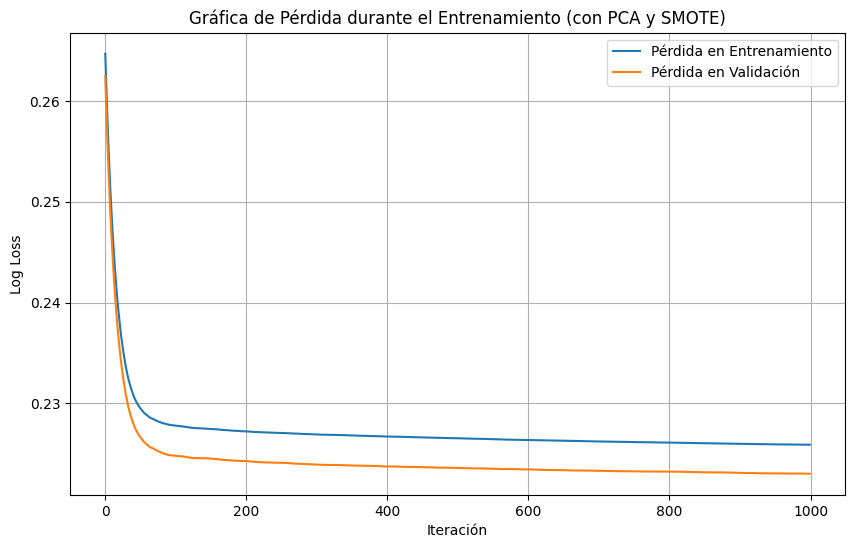

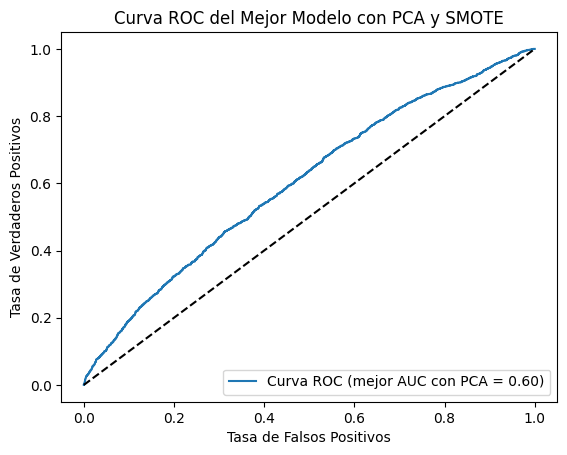

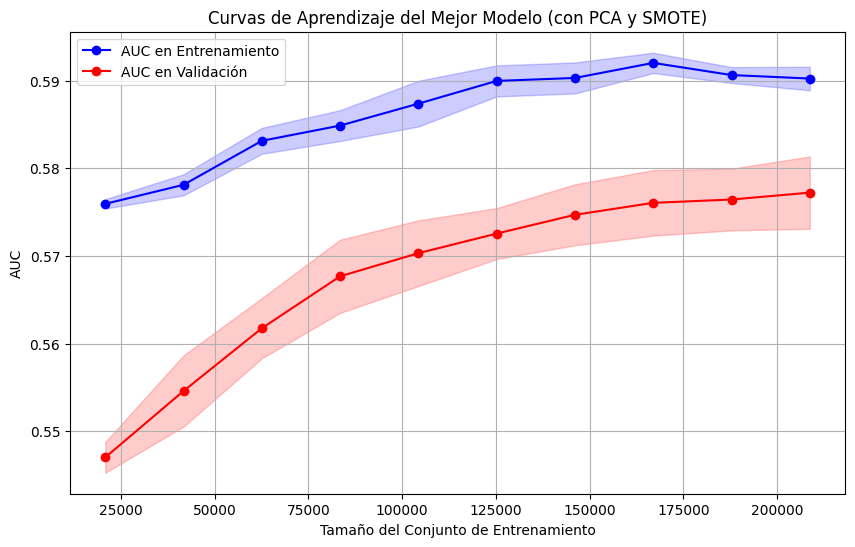

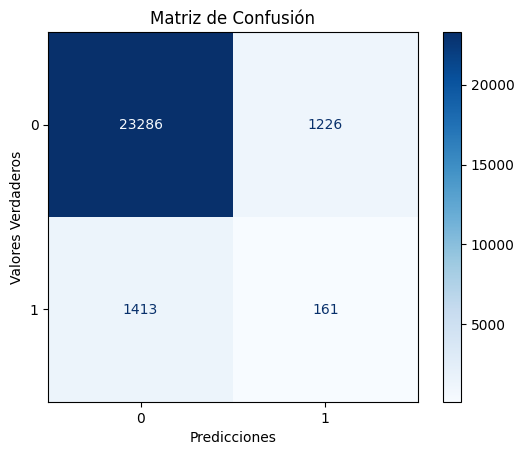

Reporte de Clasificación:
               precision    recall  f1-score   support

         0.0       0.94      0.95      0.95     24512
         1.0       0.12      0.10      0.11      1574

    accuracy                           0.90     26086
   macro avg       0.53      0.53      0.53     26086
weighted avg       0.89      0.90      0.90     26086

ROC-AUC Score: 0.6083730661392206


In [47]:
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, learning_curve
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
from xgboost import DMatrix, train, XGBClassifier
import matplotlib.pyplot as plt
import pickle

# Aplicar PCA para reducir la dimensionalidad manteniendo el 95% de la varianza
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)

# Parámetros del modelo
params = {
    'max_depth': 7,
    'min_child_weight': 200,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'eta': 0.04,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',  # Usamos logloss para monitorear la pérdida
    'seed': 42
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)
model_records = {'best_score_auc': 0, 'auc_scores': [], 'accuracy_scores': []}
best_fpr, best_tpr = None, None  # Variables para almacenar la mejor curva ROC

# Entrenamiento y evaluación en cada pliegue con los datos reducidos
for train_index, valid_index in kf.split(X_reduced):
    X_train, X_valid = X_reduced[train_index], X_reduced[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    # Convertir a DMatrix
    dtrain = DMatrix(X_train, label=y_train)
    dvalid = DMatrix(X_valid, label=y_valid)
    evals = [(dtrain, 'train'), (dvalid, 'valid')]

    # Diccionario para almacenar los resultados de evaluación
    evals_result = {}

    # Entrenar el modelo y almacenar la pérdida
    booster = train(params, dtrain, num_boost_round=1000, evals=evals, early_stopping_rounds=50, evals_result=evals_result, verbose_eval=False)

    # Realizar predicciones y calcular AUC y precisión para el pliegue actual
    predictions_proba = booster.predict(dvalid)
    predictions = [1 if p >= 0.5 else 0 for p in predictions_proba]
    auc_score = roc_auc_score(y_valid, predictions_proba)
    accuracy = accuracy_score(y_valid, predictions)
    
    model_records['auc_scores'].append(auc_score)
    model_records['accuracy_scores'].append(accuracy)

    # Almacenar el modelo y la curva ROC del mejor modelo
    if auc_score > model_records['best_score_auc']:
        model_records['best_score_auc'] = auc_score
        model_records['best_instance'] = booster
        # Curva ROC
        fpr, tpr, _ = roc_curve(y_valid, predictions_proba)
        best_fpr, best_tpr = fpr, tpr
        best_evals_result = evals_result  # Almacena el resultado de evaluación del mejor modelo

# Resultados finales
print("Promedio de AUC en validación cruzada con PCA:", np.mean(model_records['auc_scores']))
print("Mejor AUC en un solo pliegue con PCA:", model_records['best_score_auc'])
print("Promedio de precisión en validación cruzada con PCA:", np.mean(model_records['accuracy_scores']))

# Guardar el mejor modelo como versión mejorada con PCA
with open("modelo_mejorado_pca_v2.pkl", "wb") as f:
    pickle.dump(model_records['best_instance'], f)

print("Modelo mejorado con PCA guardado como 'modelo_mejorado_pca_v2.pkl'")

# =========================
# Gráfica de Pérdida en Entrenamiento y Validación del Mejor Modelo
# =========================
plt.figure(figsize=(10, 6))
plt.plot(best_evals_result['train']['logloss'], label='Pérdida en Entrenamiento')
plt.plot(best_evals_result['valid']['logloss'], label='Pérdida en Validación')
plt.xlabel("Iteración")
plt.ylabel("Log Loss")
plt.title("Gráfica de Pérdida durante el Entrenamiento (con PCA y SMOTE)")
plt.legend(loc="upper right")
plt.grid()
plt.show()

# =========================
# Curva ROC del Mejor Modelo
# =========================
plt.figure()
plt.plot(best_fpr, best_tpr, label='Curva ROC (mejor AUC con PCA = %0.2f)' % model_records['best_score_auc'])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC del Mejor Modelo con PCA y SMOTE')
plt.legend(loc="lower right")
plt.show()

# =========================
# Graficar Curvas de Aprendizaje
# =========================
train_sizes, train_scores, valid_scores = learning_curve(
    XGBClassifier(**params), X_reduced, y, cv=5, scoring='roc_auc', n_jobs=1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="AUC en Entrenamiento")
plt.plot(train_sizes, valid_mean, 'o-', color="red", label="AUC en Validación")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, color="red", alpha=0.2)
plt.title("Curvas de Aprendizaje del Mejor Modelo (con PCA y SMOTE)")
plt.xlabel("Tamaño del Conjunto de Entrenamiento")
plt.ylabel("AUC")
plt.legend(loc="best")
plt.grid()
plt.show()

# =========================
# Calcular y Graficar la Matriz de Confusión (SMOTE con Threshold de 0.3)
# =========================
# Predicciones del mejor modelo
X_valid = DMatrix(X_reduced[valid_index])  # Último conjunto de validación del mejor modelo
y_valid = y.iloc[valid_index]
y_proba = model_records['best_instance'].predict(X_valid)

# Ajustar el umbral de decisión para la Clase 1
threshold = 0.1
y_pred_adjusted = (y_proba >= threshold).astype(int)

# Calcular la matriz de confusión con el umbral ajustado
cm_adjusted = confusion_matrix(y_valid, y_pred_adjusted)
disp_adjusted = ConfusionMatrixDisplay(confusion_matrix=cm_adjusted)
disp_adjusted.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.xlabel("Predicciones")
plt.ylabel("Valores Verdaderos")
plt.show()

# =========================
# Reporte de Clasificación
# =========================
report = classification_report(y_valid, y_pred_adjusted, digits=2)
print("Reporte de Clasificación:\n", report)

# =========================
# ROC-AUC Score
# =========================
roc_auc = roc_auc_score(y_valid, y_proba)
print("ROC-AUC Score:", roc_auc)


Promedio de AUC en validación cruzada con RFM: 0.6137570787078107
Mejor AUC en un solo pliegue con RFM: 0.621693889924569
Promedio de precisión en validación cruzada con RFM: 0.9388493530166742
Modelo mejorado con RFM guardado como 'modelo_mejorado_rfm_v3.pkl'


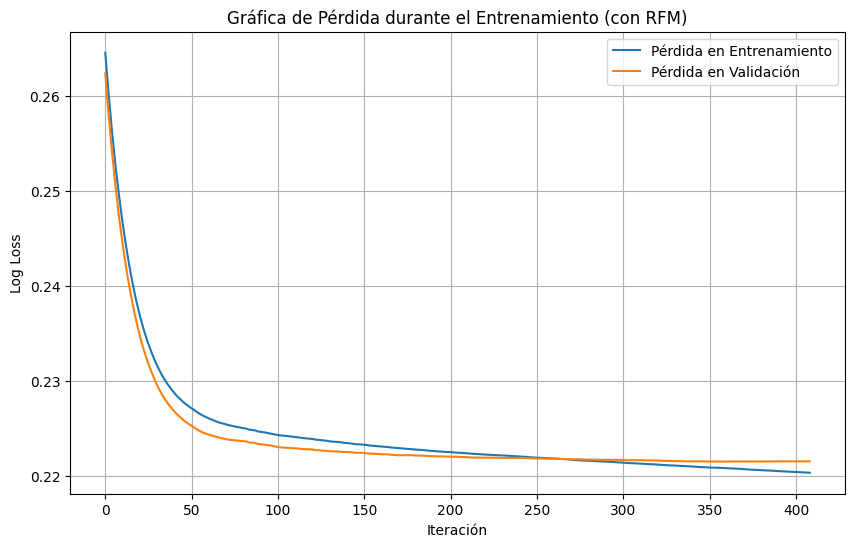

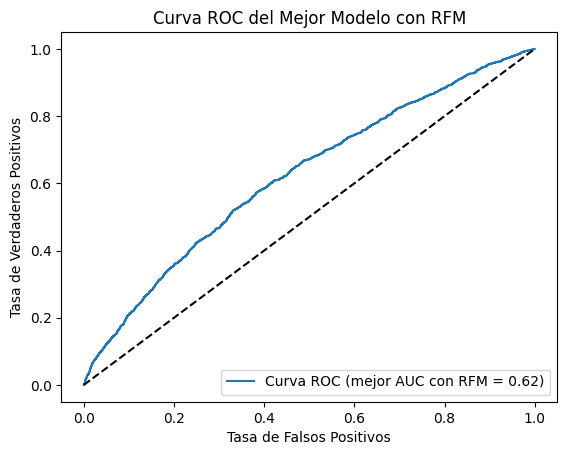

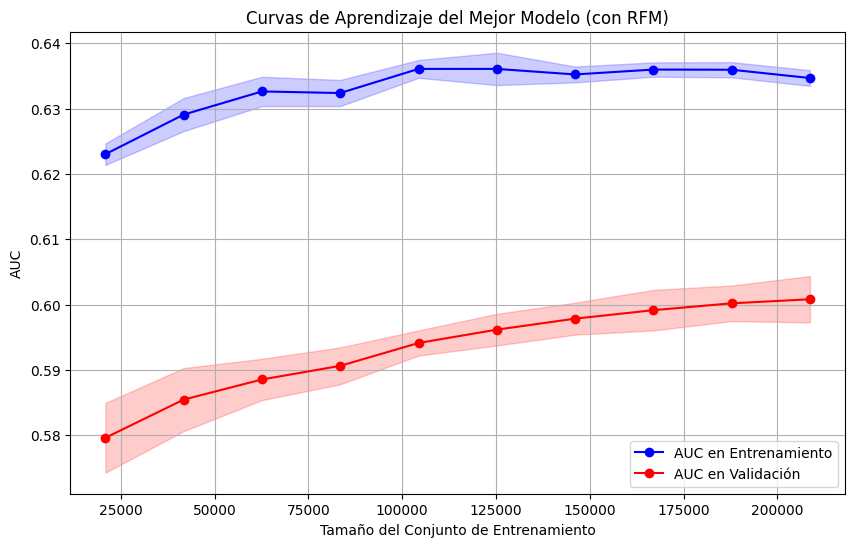

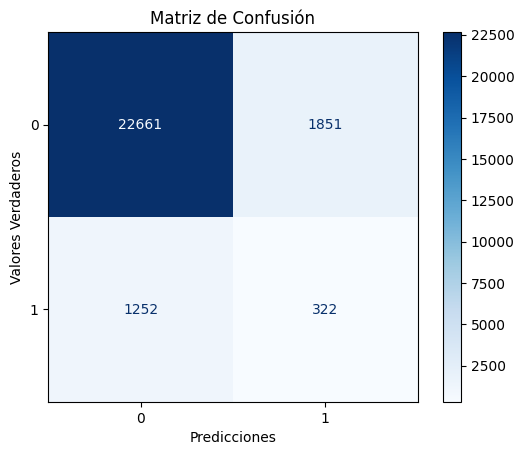

Reporte de Clasificación:
               precision    recall  f1-score   support

         0.0       0.95      0.92      0.94     24512
         1.0       0.15      0.20      0.17      1574

    accuracy                           0.88     26086
   macro avg       0.55      0.56      0.55     26086
weighted avg       0.90      0.88      0.89     26086

ROC-AUC Score: 0.6711635133044811


In [49]:
from sklearn.model_selection import KFold, learning_curve
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
from xgboost import DMatrix, train, XGBClassifier
import matplotlib.pyplot as plt
import pickle
import pandas as pd

# Calcular características RFM
log_usuarios['time_stamp'] = pd.to_datetime(log_usuarios['time_stamp'])
fecha_referencia = log_usuarios['time_stamp'].max()

rfm = log_usuarios.groupby('user_id').agg(
    recencia=('time_stamp', lambda x: (fecha_referencia - x.max()).days),
    frecuencia=('action_type', 'count'),
    valor_monetario=('action_type', lambda x: (x == 2).sum())
).reset_index()

conjunto_datos = conjunto_datos.merge(rfm, on='user_id', how='left')
X = conjunto_datos[conjunto_datos['tipo'] == 'train'].drop(['label', 'user_id', 'tipo'], axis=1)
y = conjunto_datos[conjunto_datos['tipo'] == 'train']['label']

# Parámetros del modelo
params = {
    'max_depth': 7,
    'min_child_weight': 200,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'eta': 0.04,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',  # Usamos logloss para monitorear la pérdida
    'seed': 42
}

# Configuración de K-Fold para validación cruzada
kf = KFold(n_splits=10, shuffle=True, random_state=42)
model_records = {'best_score_auc': 0, 'auc_scores': [], 'accuracy_scores': []}
best_fpr, best_tpr = None, None  # Variables para almacenar la mejor curva ROC
train_losses = []  # Pérdida en entrenamiento para cada pliegue
validation_losses = []  # Pérdida en validación para cada pliegue

# Entrenamiento y evaluación en cada pliegue con los datos RFM añadidos
for train_index, valid_index in kf.split(X):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    # Convertir a DMatrix
    dtrain = DMatrix(X_train, label=y_train)
    dvalid = DMatrix(X_valid, label=y_valid)
    evals = [(dtrain, 'train'), (dvalid, 'valid')]

    # Diccionario para almacenar los resultados de evaluación
    evals_result = {}

    # Entrenar el modelo y almacenar la pérdida
    booster = train(params, dtrain, num_boost_round=1000, evals=evals, early_stopping_rounds=50, evals_result=evals_result, verbose_eval=False)
    train_losses.append(evals_result['train']['logloss'][-1])  # Pérdida en el conjunto de entrenamiento
    validation_losses.append(evals_result['valid']['logloss'][-1])  # Pérdida en el conjunto de validación

    # Realizar predicciones y calcular AUC y precisión para el pliegue actual
    predictions_proba = booster.predict(dvalid)
    predictions = [1 if p >= 0.5 else 0 for p in predictions_proba]
    auc_score = roc_auc_score(y_valid, predictions_proba)
    accuracy = accuracy_score(y_valid, predictions)
    
    model_records['auc_scores'].append(auc_score)
    model_records['accuracy_scores'].append(accuracy)

    # Almacenar el modelo y la curva ROC del mejor modelo
    if auc_score > model_records['best_score_auc']:
        model_records['best_score_auc'] = auc_score
        model_records['best_instance'] = booster
        # Curva ROC
        fpr, tpr, _ = roc_curve(y_valid, predictions_proba)
        best_fpr, best_tpr = fpr, tpr
        best_evals_result = evals_result  # Almacena el resultado de evaluación del mejor modelo

# Resultados finales
print("Promedio de AUC en validación cruzada con RFM:", np.mean(model_records['auc_scores']))
print("Mejor AUC en un solo pliegue con RFM:", model_records['best_score_auc'])
print("Promedio de precisión en validación cruzada con RFM:", np.mean(model_records['accuracy_scores']))

# Guardar el mejor modelo como versión mejorada con RFM
with open("modelo_mejorado_rfm_v3.pkl", "wb") as f:
    pickle.dump(model_records['best_instance'], f)

print("Modelo mejorado con RFM guardado como 'modelo_mejorado_rfm_v3.pkl'")

# =========================
# Gráfica de Pérdida en Entrenamiento y Validación del Mejor Modelo
# =========================
plt.figure(figsize=(10, 6))
plt.plot(best_evals_result['train']['logloss'], label='Pérdida en Entrenamiento')
plt.plot(best_evals_result['valid']['logloss'], label='Pérdida en Validación')
plt.xlabel("Iteración")
plt.ylabel("Log Loss")
plt.title("Gráfica de Pérdida durante el Entrenamiento (con RFM)")
plt.legend(loc="upper right")
plt.grid()
plt.show()

# =========================
# Curva ROC del Mejor Modelo
# =========================
plt.figure()
plt.plot(best_fpr, best_tpr, label='Curva ROC (mejor AUC con RFM = %0.2f)' % model_records['best_score_auc'])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC del Mejor Modelo con RFM')
plt.legend(loc="lower right")
plt.show()

# =========================
# Graficar Curvas de Aprendizaje
# =========================
train_sizes, train_scores, valid_scores = learning_curve(
    XGBClassifier(**params), X, y, cv=5, scoring='roc_auc', n_jobs=1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="AUC en Entrenamiento")
plt.plot(train_sizes, valid_mean, 'o-', color="red", label="AUC en Validación")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, color="red", alpha=0.2)
plt.title("Curvas de Aprendizaje del Mejor Modelo (con RFM)")
plt.xlabel("Tamaño del Conjunto de Entrenamiento")
plt.ylabel("AUC")
plt.legend(loc="best")
plt.grid()
plt.show()

# =========================
# Calcular y Graficar la Matriz de Confusión (SMOTE con Threshold de 0.3)
# =========================
# Predicciones del mejor modelo
X_valid = DMatrix(X.iloc[valid_index])  # Último conjunto de validación del mejor modelo
y_valid = y.iloc[valid_index]
y_proba = model_records['best_instance'].predict(X_valid)

# Ajustar el umbral de decisión para la Clase 1
threshold = 0.1
y_pred_adjusted = (y_proba >= threshold).astype(int)

# Calcular la matriz de confusión con el umbral ajustado
cm_adjusted = confusion_matrix(y_valid, y_pred_adjusted)
disp_adjusted = ConfusionMatrixDisplay(confusion_matrix=cm_adjusted)
disp_adjusted.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.xlabel("Predicciones")
plt.ylabel("Valores Verdaderos")
plt.show()

# =========================
# Reporte de Clasificación
# =========================
report = classification_report(y_valid, y_pred_adjusted, digits=2)
print("Reporte de Clasificación:\n", report)

# =========================
# ROC-AUC Score
# =========================
roc_auc = roc_auc_score(y_valid, y_proba)
print("ROC-AUC Score:", roc_auc)


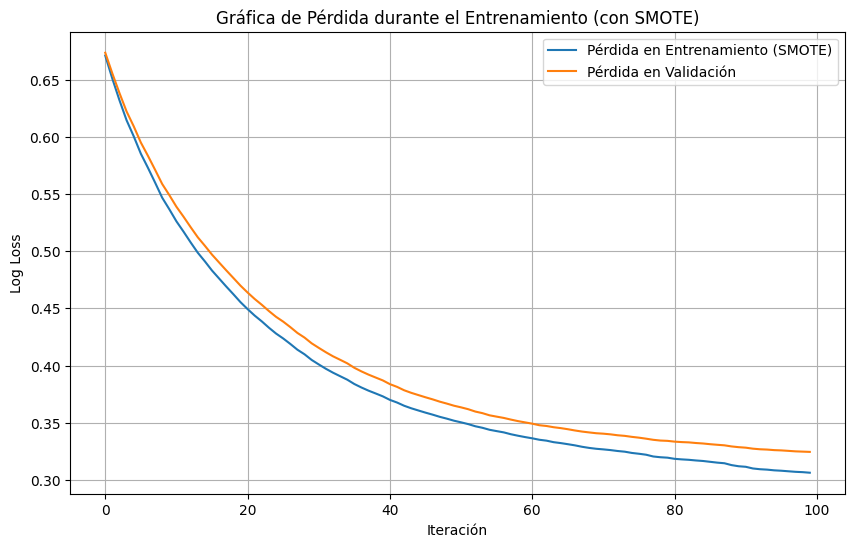

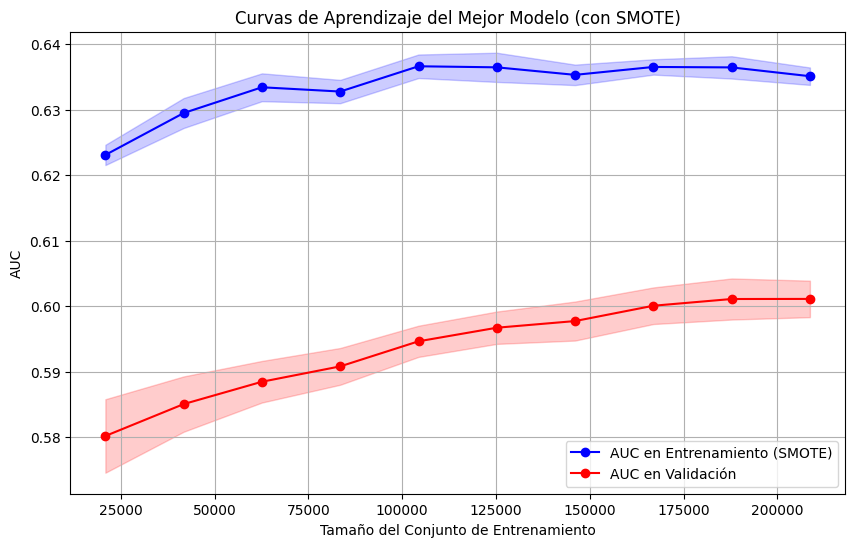

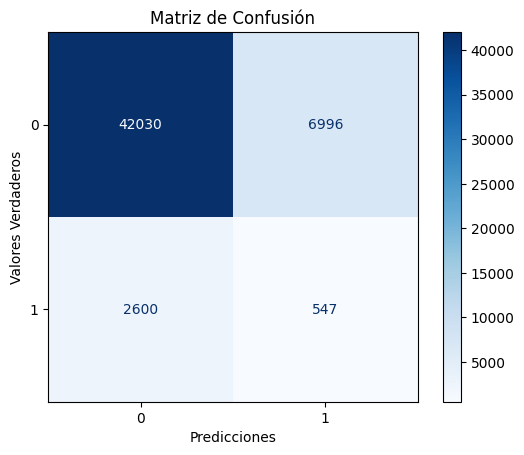

In [44]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

# =========================
# Dividir los datos en entrenamiento y validación
# =========================
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# =========================
# Aplicar SMOTE solo en el conjunto de entrenamiento
# =========================
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# =========================
# Definir y Entrenar el XGBClassifier con Datos Sobremuestreados
# =========================
xgb_model = XGBClassifier(
    max_depth=7,
    min_child_weight=200,
    colsample_bytree=0.8,
    subsample=0.8,
    learning_rate=0.04,
    objective='binary:logistic',
    eval_metric='logloss',  # Usamos log loss como métrica de pérdida
    seed=42
)

# Entrenar el modelo con el conjunto de validación para obtener la pérdida
eval_set = [(X_train_smote, y_train_smote), (X_val, y_val)]
xgb_model.fit(X_train_smote, y_train_smote, eval_set=eval_set, verbose=False)

# =========================
# Gráfica de Pérdida
# =========================
results = xgb_model.evals_result()
plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['logloss'], label='Pérdida en Entrenamiento (SMOTE)')
plt.plot(results['validation_1']['logloss'], label='Pérdida en Validación')
plt.xlabel("Iteración")
plt.ylabel("Log Loss")
plt.title("Gráfica de Pérdida durante el Entrenamiento (con SMOTE)")
plt.legend(loc="upper right")
plt.grid()
plt.show()

# =========================
# Graficar Curvas de Aprendizaje
# =========================
train_sizes, train_scores, valid_scores = learning_curve(
    xgb_model, X, y, cv=5, scoring='roc_auc', n_jobs=1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="AUC en Entrenamiento (SMOTE)")
plt.plot(train_sizes, valid_mean, 'o-', color="red", label="AUC en Validación")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, color="red", alpha=0.2)
plt.title("Curvas de Aprendizaje del Mejor Modelo (con SMOTE)")
plt.xlabel("Tamaño del Conjunto de Entrenamiento")
plt.ylabel("AUC")
plt.legend(loc="best")
plt.grid()
plt.show()

# =========================
# Calcular y Graficar la Matriz de Confusión con Umbral Ajustado
# =========================
# Realizar predicciones en el conjunto de validación
y_proba = xgb_model.predict_proba(X_val)[:, 1]

# Ajustar el umbral de decisión para la Clase 1
threshold = 0.3
y_pred_adjusted = (y_proba >= threshold).astype(int)

# Calcular la matriz de confusión con el umbral ajustado
cm_adjusted = confusion_matrix(y_val, y_pred_adjusted)
disp_adjusted = ConfusionMatrixDisplay(confusion_matrix=cm_adjusted)
disp_adjusted.plot(cmap=plt.cm.Blues)
plt.title(f"Matriz de Confusión")
plt.xlabel("Predicciones")
plt.ylabel("Valores Verdaderos")
plt.show()


In [37]:
from sklearn.metrics import classification_report

# =========================
# Calcular el Reporte de Clasificación
# =========================
# Realizar predicciones ajustando el umbral para la clase positiva
y_pred_adjusted = (y_proba >= threshold).astype(int)

# Generar el reporte de clasificación
report = classification_report(y_val, y_pred_adjusted, digits=2)
print("Reporte de Clasificación:\n", report)

from sklearn.metrics import roc_auc_score

# Calcular el ROC-AUC Score en el conjunto de validación
roc_auc = roc_auc_score(y_val, y_proba)
print("ROC-AUC Score:", roc_auc)

Reporte de Clasificación:
               precision    recall  f1-score   support

         0.0       0.94      0.86      0.90     49026
         1.0       0.07      0.17      0.10      3147

    accuracy                           0.82     52173
   macro avg       0.51      0.52      0.50     52173
weighted avg       0.89      0.82      0.85     52173

ROC-AUC Score: 0.5360777873535739
